https://www.cnblogs.com/king-lps/p/8724361.html

# 生成验证码

In [17]:
# Put these at the top of every notebook, to get automatic reloading and inline plotting
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [18]:
# -*- coding: utf-8 -*-
from captcha.image import ImageCaptcha
import numpy as np
#import matplotlib.pyplot as plt
from PIL import Image
import random 
import cv2
import numpy as np
import os
import copy, time
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable 
import torch.optim as optim
import torchvision.models as models
import torchvision
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw, ImageFont


In [22]:


# number = ['0','1','2','3','4','5','6','7','8','9']
# alphabet = ['a','b','c','d','e','f','g','h','i','j','k','l','m','n','o','p','q','r','s','t','u','v','w','x','y','z',':',',','[',']']
# # ALPHABET = ['A','B','C','D','E','F','G','H','I','J','K','L','M','N','O','P','Q','R','S','T','U','V','W','X','Y','Z']
# ALPHABET = ['A','B','C','D','E','F','.','■','□']
def random_color(start, end, opacity=None):
    red = random.randint(start, end)
    green = random.randint(start, end)
    blue = random.randint(start, end)
    if opacity is None:
        return (red, green, blue)
    return (red, green, blue, opacity)


data_path = './data/captcha/'
alphabet = 'abcdefgABCDEFG1234567890.:[]■□题'
def random_captcha_text(char_set=alphabet,captcha_size=6):    # 可以设置只用来生成数字
    captcha_text = []
    for i in range(captcha_size):
        c = random.choice(char_set)
        captcha_text.append(c)
    return captcha_text

def gen_capthcha_text_and_image(m, fontsize,color=(0, 0, 0),fontName=u"simsunb.ttf", nosis=True):
#     image = ImageCaptcha()
#     captcha_text = random_captcha_text(captcha_size=random.randint(4,8))     # 生成数字
    captcha_text = random_captcha_text(captcha_size=6)     # 生成数字
    captcha_text = ' '.join(captcha_text)  # 生成标签

    background = random_color(170, 255)
    image = Image.new("RGB", (256, 48), background)  # 注意因为pytorch dataloader 加载数据需要加载定长的数据，所以长、宽写死
    font = ImageFont.truetype(fontName, fontsize)
    draw = ImageDraw.Draw(image)
    draw.text((10, 10), captcha_text, fill=color, font=font)
    color = (0,0,0)

#     if nosis:
#         # 加噪点
#         w, h = image.size
#         r_x = 250/w

#         number=14
#         width=2
#         while number:
#             x1 = random.randint(0, w)
#             y1 = random.randint(0, h)
#             draw.line(((x1, y1), (x1 - 1, y1 - 1)), fill=color, width=width)
#             number -= 1

    
#     captcha_image = Image.open(captcha)

    captcha_image = np.array(image)
    captcha_image = cv2.cvtColor(captcha_image, cv2.COLOR_BGR2GRAY)
    
    
    
    ret, captcha_image = cv2.threshold(np.array(captcha_image), 100, 255,cv2.THRESH_BINARY)
    captcha_image = cv2.blur(captcha_image,(3,3))
    
    with open(data_path+"label.txt","a") as f:     # 写入标签
#             print(captcha_text.strip())
            captcha_text = captcha_text.replace(' ','')
            f.write(captcha_text)
            f.writelines("\n")  
    cv2.imwrite(data_path + 'src/'+'%.4d.jpg'%m,  captcha_image)   # 保存
    
if __name__ == '__main__':
    
    for m in range(0,500):
          gen_capthcha_text_and_image(m,40)    



#     for m in range(1000,1500):
#           gen_capthcha_text_and_image(m,24)  
            
#     for m in range(1500,2000):
#           gen_capthcha_text_and_image(m,16,nosis=False)              

# 数据转码

In [19]:
class strLabelConverter(object):
    def __init__(self, alphabet):
        self.alphabet = alphabet + u'-'  # for `-1` index
        self.dict = {}
        for i, char in enumerate(alphabet):
            # NOTE: 0 is reserved for 'blank' required by wrap_ctc
            self.dict[char] = i + 1

    def encode(self, text, depth=0):
        """Support batch or single str."""
        length = []
        result = []
        for str in text:
            # str = unicode(str, "utf8")    # python 3 默认为utf 8
            length.append(len(str))
            for char in str:
                # print(char)
                index = self.dict[char]
                result.append(index)
        text = result
        return (torch.IntTensor(text), torch.IntTensor(length))

    def decode(self, t, length, raw=False):
        if length.numel() == 1:
            length = length[0]
            t = t[:length]
            if raw:
                return ''.join([self.alphabet[i - 1] for i in t])
            else:
                char_list = []
                for i in range(length):
                    if t[i] != 0 and (not (i > 0 and t[i - 1] == t[i])):
                        char_list.append(self.alphabet[t[i] - 1])
                return ''.join(char_list)
        else:
            texts = []
            index = 0
            for i in range(length.numel()):
                l = length[i]
                texts.append(self.decode(
                    t[index:index + l], torch.IntTensor([l]), raw=raw))
                index += l
            return texts


In [183]:
atxt = '题12■□'
convert = strLabelConverter(atxt)

def loadData(v, data):
    v.data.resize_(data.size()).copy_(data)
# for char in atxt:
#     print(char)
echar,el = convert.encode(atxt)
print(echar,':',el)
length = Variable(torch.IntTensor(1))
loadData(length,el)

print(convert.decode(echar,length ))


tensor([1, 2, 3, 4, 5], dtype=torch.int32) : tensor([1, 1, 1, 1, 1], dtype=torch.int32)
['题', '1', '2', '■', '□']


# 数据处理

In [20]:
# Load data
class dataset(Dataset):
      
    def __init__(self, root_dir, label_file, transform=None):
            self.root_dir = root_dir
            self.label = np.loadtxt(file_path+'/label.txt',unpack=True,dtype=str)
            self.transform = transform
            
    def __getitem__(self, idx):
            
            img_name = os.path.join(self.root_dir,'%.4d.jpg'%idx)
#             print(idx,':',img_name)
#             image = Image.open(img_name)
            image = Image.open(img_name).convert('L')    # 转成灰度图 1, W, H
            labels = self.label[idx]
           
            if self.transform:
                 image = self.transform(image)

            return image, labels
            
    def __len__(self):
            return (self.label.shape[0])

In [21]:
file_path = './data/captcha/'
BATCH_SIZE = 16
alphabet = 'abcdefgABCDEFG1234567890.:[]■□题'
data = dataset(file_path+'src', file_path+'/label.txt',transform=transforms.ToTensor())
dataloader = DataLoader(data, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)
dataset_size = len(data)

# for step,(inputs,label) in enumerate(dataloader):
#     print(label)

In [22]:
print(dataset_size)
mm = iter(dataloader)
input, label = mm.next()
print(label)
# label = np.array(label)
# label.reshape(1,label.shape[0])
# print(label)

500
('6gDdgc', 'd6..□G', 'GB3Fb.', '155F27', 'DBF6c5', 'A46e6a', '13题F5□', '09d2A:', '4a55Fd', 'D56c■题', 'D1AdEF', 'B0GDD■', ':9c7:□', '题G6[■题', '7eD0Fg', '■2B2c1')


# Conv network

In [23]:
class ConvNet(nn.Module):
      
    def __init__(self,nclass):
        super(ConvNet, self).__init__()
        self.nclass = nclass
        self.conv =nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=4, stride=1, padding=2), # in:(bs,1,60,160)
            nn.BatchNorm2d(32),
            nn.LeakyReLU(0.2, inplace=True),     
            nn.MaxPool2d(kernel_size=2),        # out:(bs,32,30,80)
                        
            nn.Conv2d(32, 64, kernel_size=4, stride=1, padding=2),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2, inplace=True),
            nn.MaxPool2d(kernel_size=2),        # out:(bs,64,15,40)
                        
            nn.Conv2d(64, 64, kernel_size=3 ,stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2, inplace=True),     
            nn.MaxPool2d(kernel_size=2),         # out:(bs,64,7,20)
            
            nn.Conv2d(64, 64,kernel_size=(2,1), stride=(4,1),padding=(1,0)),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2, inplace=True),   
            nn.MaxPool2d(kernel_size=(2,1))         # out:(bs,64,1,20) b, c, h, w
         
        )
#         self.fc1 = nn.Linear(64*7*20, 500)
#         self.fc2 = nn.Linear(500,40)
#         self.fc1 = nn.Linear(64, 500)
#         self.fc2 = nn.Linear(500,self.nclass)            # 分成10类  {0,1,2,...9}
        
        self.rnn1 = nn.LSTM(64,512,batch_first=False)
        self.rnn2 = nn.LSTM(512, self.nclass, batch_first=False)
      
    def forward(self, x):
        x = self.conv(x)
        
        b, c, h, w = x.size()        # batch_size, classes, height, weight
        x = x.permute(3,0,1,2)    # 将X转换成 batch size, weight, classes, height
        

        #  采用Linear方式实现
#         x = x.contiguous().view(w*b, -1)  # reshape to (batch_size, 64 * 1 * 20)
#         output = self.fc1(x)
#         output = self.fc2(output)
#         output = output.view(w,b,-1)

        # 采用LSTM方式实现
        x = x.contiguous().view(w,b,-1) #  reshape to (batch_size,width, 64 )
        output,_ = self.rnn1(x)       # ouput  (batch_size,width, 256 )
        output,_ = self.rnn2(output)  # ouput  (batch_size,width, 11 )
        return output
#         return output
    
    
class nCrossEntropyLoss(torch.nn.Module):

    def __init__(self, n=4):
        super(nCrossEntropyLoss, self).__init__()
        self.n = n
        self.total_loss = 0
        self.loss = nn.CrossEntropyLoss()
        
    def forward(self, output, label):
        output_t = output[:,0:10]
        label = Variable(torch.LongTensor(label.data.cpu().numpy()))
        label_t = label[:,0]
            
        for i in range(1, self.n):
            # 损失的思路是将一张图平均剪切为4张小图即4个多分类，然后再用多分类交叉熵方损失
            output_t = torch.cat((output_t, output[:,10*i:10*i+10]), 0)   
            label_t = torch.cat((label_t, label[:,i]), 0)         
            self.total_loss = self.loss(output_t, label_t)
        return self.total_loss

def equal(np1,np2):
    n = 0
    for i in range(np1.shape[0]):
        if (np1[i,:]==np2[i,:]).all():
            n += 1 
    return n    


In [47]:
def loadData(v, data):
    v.data.resize_(data.size()).copy_(data)
length = Variable(torch.IntTensor(BATCH_SIZE))
tl = []
for i in range(BATCH_SIZE):
    tl.append(4)
tl = torch.IntTensor(tl)
print(tl)
loadData(length, tl)
print(length)

tensor([4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4], dtype=torch.int32)
tensor([4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4], dtype=torch.int32)


In [13]:
tl.size()


torch.Size([16])

# 训练网络

In [25]:
from warpctc_pytorch import CTCLoss  



    

def loadData(v, data):
    v.data.resize_(data.size()).copy_(data)

print(dataset_size)
net = ConvNet(nclass=len(alphabet) + 1)
net.load_state_dict(torch.load(file_path+'/best_model_wts.pkl'))
optimizer = torch.optim.Adam(net.parameters(), lr=0.001)
convert = strLabelConverter(alphabet)
# loss_func = nCrossEntropyLoss()
loss_func = CTCLoss()      # 将损失函数修改成CTCLoss

best_model_wts = copy.deepcopy(net.state_dict())  
best_acc = 0.0   
since = time.time()
EPOCH = 10000
length = Variable(torch.IntTensor(BATCH_SIZE))

output = None
loss = 0.0
for epoch in range(EPOCH):
    running_loss=0.0
    running_corrects=0
    
    for step,(inputs,label) in enumerate(dataloader):
        pred = torch.LongTensor(BATCH_SIZE,1).zero_()
        
        inputs = Variable(inputs)   # (bs, 3, 60, 240)
        
#         label = Variable(label.int())   # (bs, 4)
        
        label = np.array(label)
        label_text = label
        label,label_len = convert.encode(label)
        loadData(length,label_len)
        optimizer.zero_grad() 
        
        output = net(inputs)   # (bs, 40)
#         print('pred output size : ',output.size())
        preds_size = Variable(torch.IntTensor([output.size(0)] * BATCH_SIZE))
        
        label = label.view(-1)

        loss = loss_func(output, label, preds_size,length )/ BATCH_SIZE
        
#         print("loss --> " ,loss)

        mnum, preds = output.max(2)
        preds = preds.transpose(1, 0).contiguous().view(-1)
        preds_size = Variable(torch.IntTensor([preds.size(0)]))      
        preds_text = convert.decode(preds.data, preds_size.data, raw=False)
      
        loss.backward()
        optimizer.step()
            
        running_loss += loss.data[0] * inputs.size()[0]
#         print('preds text: ',preds_text)
#         print('-----------------------')
#         print('label texts:',label_text)
        for pred, target in zip(preds_text, label_text):
            if pred.strip() == target.strip():
                print('pred text:', pred.strip(), ' target text :', target.strip())
                running_corrects += 1
#         running_corrects += equal(pred.numpy()[:,1:], label.data.cpu().numpy().astype(int))
                        
    epoch_loss = running_loss / dataset_size
    epoch_acc  = running_corrects / dataset_size
                  
#     if  epoch_acc > best_acc:   
#         best_acc = epoch_acc
    best_model_wts = copy.deepcopy(net.state_dict())  
            
#     if epoch == EPOCH-1:
    torch.save(best_model_wts, file_path+'/best_model_wts.pkl')
            
    print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
                   time_elapsed // 60, time_elapsed % 60))
    print('Train Loss:{:.4f} Acc: {:.4f}'.format(epoch_loss, epoch_acc))
    if epoch_loss < 0.05:
        break;
    
print('训练完成')

500

Training complete in 0m 32s
Train Loss:50.2835 Acc: 0.0000

Training complete in 1m 4s
Train Loss:50.2835 Acc: 0.0000

Training complete in 1m 45s
Train Loss:50.2831 Acc: 0.0000

Training complete in 2m 24s
Train Loss:50.2835 Acc: 0.0000

Training complete in 2m 56s
Train Loss:50.2831 Acc: 0.0000

Training complete in 3m 29s
Train Loss:50.2831 Acc: 0.0000

Training complete in 4m 1s
Train Loss:50.2835 Acc: 0.0000

Training complete in 4m 33s
Train Loss:50.2835 Acc: 0.0000

Training complete in 5m 13s
Train Loss:50.2835 Acc: 0.0000

Training complete in 5m 44s
Train Loss:50.2835 Acc: 0.0000

Training complete in 6m 13s
Train Loss:50.2835 Acc: 0.0000

Training complete in 6m 44s
Train Loss:50.2835 Acc: 0.0000

Training complete in 7m 14s
Train Loss:50.2831 Acc: 0.0000

Training complete in 7m 43s
Train Loss:50.2831 Acc: 0.0000

Training complete in 8m 12s
Train Loss:50.2831 Acc: 0.0000

Training complete in 8m 42s
Train Loss:50.2835 Acc: 0.0000

Training complete in 9m 13s
Train Los


Training complete in 70m 18s
Train Loss:50.2831 Acc: 0.0000

Training complete in 70m 49s
Train Loss:50.2835 Acc: 0.0000

Training complete in 71m 20s
Train Loss:50.2835 Acc: 0.0000

Training complete in 71m 52s
Train Loss:50.2831 Acc: 0.0000

Training complete in 72m 22s
Train Loss:50.2835 Acc: 0.0000

Training complete in 72m 53s
Train Loss:50.2831 Acc: 0.0000

Training complete in 73m 25s
Train Loss:50.2827 Acc: 0.0000

Training complete in 73m 58s
Train Loss:50.2835 Acc: 0.0000

Training complete in 74m 28s
Train Loss:50.2835 Acc: 0.0000

Training complete in 74m 59s
Train Loss:50.2827 Acc: 0.0000

Training complete in 75m 29s
Train Loss:50.2831 Acc: 0.0000

Training complete in 75m 60s
Train Loss:50.2835 Acc: 0.0000

Training complete in 76m 31s
Train Loss:50.2827 Acc: 0.0000

Training complete in 77m 2s
Train Loss:50.2826 Acc: 0.0000

Training complete in 77m 32s
Train Loss:50.2831 Acc: 0.0000

Training complete in 78m 4s
Train Loss:50.2835 Acc: 0.0000

Training complete in 78m 


Training complete in 140m 17s
Train Loss:50.2831 Acc: 0.0000

Training complete in 140m 48s
Train Loss:50.2831 Acc: 0.0000

Training complete in 141m 19s
Train Loss:50.2835 Acc: 0.0000

Training complete in 141m 50s
Train Loss:50.2831 Acc: 0.0000

Training complete in 142m 22s
Train Loss:50.2831 Acc: 0.0000

Training complete in 142m 53s
Train Loss:50.2831 Acc: 0.0000

Training complete in 143m 24s
Train Loss:50.2835 Acc: 0.0000

Training complete in 143m 55s
Train Loss:50.2835 Acc: 0.0000

Training complete in 144m 26s
Train Loss:50.2831 Acc: 0.0000

Training complete in 144m 58s
Train Loss:50.2835 Acc: 0.0000

Training complete in 145m 29s
Train Loss:50.2835 Acc: 0.0000

Training complete in 146m 1s
Train Loss:50.2835 Acc: 0.0000

Training complete in 146m 33s
Train Loss:50.2835 Acc: 0.0000

Training complete in 147m 4s
Train Loss:50.2831 Acc: 0.0000

Training complete in 147m 35s
Train Loss:50.2831 Acc: 0.0000

Training complete in 148m 6s
Train Loss:50.2827 Acc: 0.0000

Training c


Training complete in 208m 60s
Train Loss:50.2835 Acc: 0.0000

Training complete in 209m 30s
Train Loss:50.2831 Acc: 0.0000

Training complete in 209m 60s
Train Loss:50.2831 Acc: 0.0000

Training complete in 210m 29s
Train Loss:50.2827 Acc: 0.0000

Training complete in 210m 60s
Train Loss:50.2835 Acc: 0.0000

Training complete in 211m 29s
Train Loss:50.2835 Acc: 0.0000

Training complete in 211m 59s
Train Loss:50.2835 Acc: 0.0000

Training complete in 212m 29s
Train Loss:50.2835 Acc: 0.0000

Training complete in 212m 59s
Train Loss:50.2831 Acc: 0.0000

Training complete in 213m 29s
Train Loss:50.2835 Acc: 0.0000

Training complete in 214m 1s
Train Loss:50.2835 Acc: 0.0000

Training complete in 214m 32s
Train Loss:50.2835 Acc: 0.0000

Training complete in 215m 2s
Train Loss:50.2835 Acc: 0.0000

Training complete in 215m 32s
Train Loss:50.2835 Acc: 0.0000

Training complete in 216m 4s
Train Loss:50.2831 Acc: 0.0000

Training complete in 216m 36s
Train Loss:50.2835 Acc: 0.0000

Training c


Training complete in 277m 46s
Train Loss:50.2831 Acc: 0.0000

Training complete in 278m 17s
Train Loss:50.2835 Acc: 0.0000

Training complete in 278m 47s
Train Loss:50.2835 Acc: 0.0000

Training complete in 279m 18s
Train Loss:50.2831 Acc: 0.0000

Training complete in 279m 49s
Train Loss:50.2831 Acc: 0.0000

Training complete in 280m 19s
Train Loss:50.2835 Acc: 0.0000

Training complete in 280m 50s
Train Loss:50.2831 Acc: 0.0000

Training complete in 281m 21s
Train Loss:50.2835 Acc: 0.0000

Training complete in 281m 52s
Train Loss:50.2835 Acc: 0.0000

Training complete in 282m 23s
Train Loss:50.2827 Acc: 0.0000

Training complete in 282m 53s
Train Loss:50.2831 Acc: 0.0000

Training complete in 283m 24s
Train Loss:50.2835 Acc: 0.0000

Training complete in 283m 55s
Train Loss:50.2835 Acc: 0.0000

Training complete in 284m 26s
Train Loss:50.2831 Acc: 0.0000

Training complete in 284m 57s
Train Loss:50.2831 Acc: 0.0000

Training complete in 285m 27s
Train Loss:50.2835 Acc: 0.0000

Trainin


Training complete in 349m 18s
Train Loss:50.2835 Acc: 0.0000

Training complete in 349m 49s
Train Loss:50.2835 Acc: 0.0000

Training complete in 350m 21s
Train Loss:50.2835 Acc: 0.0000

Training complete in 350m 55s
Train Loss:50.2827 Acc: 0.0000

Training complete in 351m 29s
Train Loss:50.2835 Acc: 0.0000


KeyboardInterrupt: 

# 验证网络

./data/captcha//best_model_wts.pkl


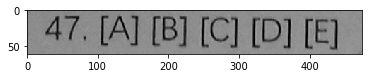

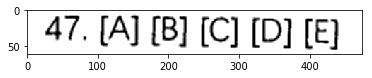

torch.Size([1, 1, 62, 474])
torch.Size([59, 1, 32])


In [35]:
net = ConvNet(nclass=len(alphabet) + 1)
net.load_state_dict(torch.load(file_path+'/best_model_wts.pkl'))
net.eval()
print(file_path+'/best_model_wts.pkl')
image = Image.open('/home/hecong/3.jpg').convert('L')

plt.imshow(image,'gray')
plt.show()
ret, image = cv2.threshold(np.array(image), 100, 255,cv2.THRESH_BINARY)
image = cv2.blur(image,(3,3))
image = Image.fromarray(image)
plt.imshow(image,'gray')
plt.show()
# image = Image.open('./data/captcha/src/1299.jpg').convert('L')

# plt.imshow(image,'gray')
# plt.show()

# image = image.transpose([2,0,1])
transform = transforms.ToTensor()  # ??? 会将图片数据255 转成 0.96...，需要看一下实现
image = transform(image)
# image = image.permute(1,2,0)
image = image.unsqueeze(0)
print(image.size())

net.eval()
output = net(Variable(image))
print(output.size())


In [36]:
mnum, preds = output.max(2)

preds = preds.transpose(1, 0).contiguous().view(-1)
preds_size = Variable(torch.IntTensor([preds.size(0)]))      
preds_text = convert.decode(preds.data, preds_size.data)
print(preds_text)



9ECF


In [79]:
image = ImageCaptcha()
??image.generate_image